In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from Excel files
books_df = pd.read_excel("../Data/Lektury_szkolne_baza.xlsx")
promotions_df = pd.read_excel("../Data/promocje_księgarnie.xlsx")

# Normalize column names (remove spaces, lowercase)
books_df.columns = books_df.columns.str.strip().str.lower()
promotions_df.columns = promotions_df.columns.str.strip().str.lower()

# Find the column with formula (e.g., "formuła_promo")
formula_col = next((col for col in promotions_df.columns if 'formuła' in col), None)
if formula_col is None:
    raise ValueError("Promotion formula column not found.")


In [38]:
# Function to calculate total price with shipping and promotion
def calculate_total_price(store_id, books, promo_dict):
    prices = list(books['cena książki'])
    shipping_cost = books['cena dostawy'].iloc[0]
    total_price = sum(prices)

    # Apply promotion if available
    formula = promo_dict.get(store_id)
    if pd.notna(formula):
        local_vars = {'prices': sorted(prices), 'total_price': total_price, 'shipping_cost': shipping_cost}
        try:
            exec(formula, {}, local_vars)
            total_price = local_vars.get('total_price', total_price)
            shipping_cost = local_vars.get('shipping_cost', shipping_cost)
        except Exception as e:
            print(f"⚠️ Promotion error for store {store_id}: {e}")
    
    return total_price + shipping_cost


In [39]:
def scalable_strategy(wishlist, promo_dict):
    # Select the cheapest offer for each book
    selected = []
    for title in wishlist:
        offers = books_df[books_df['nazwa książki'] == title]
        if offers.empty:
            print(f"⚠️ Book not found: {title}")
            continue
        # Choose the cheapest offer (without promotion)
        best_offer = offers.loc[offers['cena książki'].idxmin()]
        selected.append(best_offer)

    selected_df = pd.DataFrame(selected)
    # Group by bookstore
    grouped = selected_df.groupby('id księgarni')

    total_cost = 0
    used_promos = {}
    for store_id, group in grouped:
        prices = list(group['cena książki'])
        shipping_cost = group['cena dostawy'].iloc[0]
        total_price = sum(prices)

        formula = promo_dict.get(store_id)
        if pd.notna(formula):
            local_vars = {'prices': sorted(prices), 'total_price': total_price, 'shipping_cost': shipping_cost}
            try:
                exec(formula, {}, local_vars)
                total_price = local_vars.get('total_price', total_price)
                shipping_cost = local_vars.get('shipping_cost', shipping_cost)
                used_promos[store_id] = formula.strip()
            except Exception as e:
                print(f"⚠️ Promotion error for store {store_id}: {e}")

        total_cost += total_price + shipping_cost

    print(f"\n💡 Scalable strategy total cost: {total_cost:.2f} zł")
    print("Promotions used:")
    if used_promos:
        for store_id, formula in used_promos.items():
            print(f"Store {store_id}: {formula}")
    else:
        print("None")
    return total_cost

# Prepare promotion dictionary
promo_dict = {
    row['id_księgarni']: row[formula_col]
    for _, row in promotions_df.iterrows()
}

# Example usage:
scalable_strategy(books, promo_dict)



💡 Scalable strategy total cost: 128.50 zł
Promotions used:
Store 3: total_price -= sum(prices[:len(prices)//3])
Store 4: if len(prices) >= 3: total_price *= 0.9


128.5

In [40]:
import itertools

def compare_all_strategies(wishlist, test_name="Test"):
    print(f"\n📚 {test_name} – Books to buy: {wishlist}")

    wishlist_df = books_df[books_df['nazwa książki'].isin(wishlist)].copy()
    if wishlist_df.empty:
        print("❌ No books from the wishlist found.")
        return

    grouped_by_store = wishlist_df.groupby('id księgarni')

    promo_dict = {
        row['id_księgarni']: row[formula_col]
        for _, row in promotions_df.iterrows()
    }

    ### OPTION 1: All books in one store
    single_store_options = {}
    for store_id, books in grouped_by_store:
        if set(wishlist).issubset(set(books['nazwa książki'])):
            total = calculate_total_price(store_id, books[books['nazwa książki'].isin(wishlist)], promo_dict)
            single_store_options[store_id] = total

    ### OPTION 2: Cheapest book per title
    cheapest_books = []
    for title in wishlist:
        book_options = wishlist_df[wishlist_df['nazwa książki'] == title]
        if book_options.empty:
            print(f"⚠️ Book not found: {title}")
            continue
        cheapest = book_options.loc[book_options['cena książki'].idxmin()]
        cheapest_books.append(cheapest)

    cheapest_df = pd.DataFrame(cheapest_books)
    cheapest_total = 0
    used_promos_option2 = {}
    for store_id, group in cheapest_df.groupby('id księgarni'):
        prices = list(group['cena książki'])
        shipping_cost = group['cena dostawy'].iloc[0]
        total_price = sum(prices)

        formula = promo_dict.get(store_id)
        if pd.notna(formula):
            local_vars = {'prices': sorted(prices), 'total_price': total_price, 'shipping_cost': shipping_cost}
            try:
                exec(formula, {}, local_vars)
                total_price = local_vars.get('total_price', total_price)
                shipping_cost = local_vars.get('shipping_cost', shipping_cost)
                used_promos_option2[store_id] = formula.strip()
            except:
                pass

        cheapest_total += total_price + shipping_cost

    ### OPTION 3: Optimal combination
    book_options = []
    for book in wishlist:
        options = wishlist_df[wishlist_df['nazwa książki'] == book]
        if options.empty:
            print(f"⚠️ Book not available in any store: {book}")
            return
        book_options.append(options.to_dict(orient='records'))

    all_combinations = list(itertools.product(*book_options))
    best_price = float('inf')
    best_plan = None

    for combo in all_combinations:
        combo_df = pd.DataFrame(combo)
        store_groups = combo_df.groupby('id księgarni')

        total_cost = 0
        used_promos = {}
        for store_id, group in store_groups:
            prices = list(group['cena książki'])
            shipping_cost = group['cena dostawy'].iloc[0]
            total_price = sum(prices)

            formula = promo_dict.get(store_id)
            if pd.notna(formula):
                local_vars = {'prices': sorted(prices), 'total_price': total_price, 'shipping_cost': shipping_cost}
                try:
                    exec(formula, {}, local_vars)
                    total_price = local_vars.get('total_price', total_price)
                    shipping_cost = local_vars.get('shipping_cost', shipping_cost)
                    used_promos[store_id] = formula.strip()
                except:
                    pass

            total_cost += total_price + shipping_cost

        if total_cost < best_price:
            best_price = total_cost
            best_plan = {
                'combo': combo_df,
                'total_cost': total_cost,
                'promotions': used_promos
            }

    ### OUTPUT RESULTS
    print("\n💰 Option 1 – All books in one bookstore:")
    if single_store_options:
        for store, price in single_store_options.items():
            print(f"🏪 Bookstore {store}: {price:.2f} zł")
    else:
        print("🚫 No bookstore has the full set.")

    print(f"\n💰 Option 2 – Cheapest store per book: {cheapest_total:.2f} zł")
    print("\n🏷️ Promotions used (Option 2):")
    if used_promos_option2:
        for store_id, formula in used_promos_option2.items():
            print(f"Store {store_id}: {formula}")
    else:
        print("None")

    print(f"\n💰 Option 3 – Optimal mixed-store combination: {best_price:.2f} zł")
    print("\n📦 Bookstore assignments (Option 3):")
    for _, row in best_plan['combo'].iterrows():
        print(f"📘 {row['nazwa książki']} – Store {row['id księgarni']} – {row['cena książki']} zł")
    print("\n🏷️ Promotions used (Option 3):")
    if best_plan['promotions']:
        for store_id, formula in best_plan['promotions'].items():
            print(f"Store {store_id}: {formula}")
    else:
        print("None")

    return (
        test_name,
        min(single_store_options.values()) if single_store_options else None,
        cheapest_total,
        best_price
    )



--- Test 1 – Basics ---

📚 Test 1 – Basics – Books to buy: ['Opowieści z Narnii: Lew, czarownica i stara szafa', 'W pustyni i w puszczy', 'Akademia pana Kleksa', 'Chłopcy z Placu Broni']

💰 Option 1 – All books in one bookstore:
🏪 Bookstore 1: 107.00 zł
🏪 Bookstore 2: 115.50 zł
🏪 Bookstore 3: 96.00 zł
🏪 Bookstore 4: 98.20 zł
🏪 Bookstore 5: 96.00 zł

💰 Option 2 – Cheapest store per book: 115.50 zł

🏷️ Promotions used (Option 2):
Store 1: if total_price >= 100: shipping_cost = 0
Store 4: if len(prices) >= 3: total_price *= 0.9
Store 5: if len(prices) >= 2: total_price -= sorted(prices)[1] * 0.3

💰 Option 3 – Optimal mixed-store combination: 91.00 zł

📦 Bookstore assignments (Option 3):
📘 Opowieści z Narnii: Lew, czarownica i stara szafa – Store 3 – 29.0 zł
📘 W pustyni i w puszczy – Store 3 – 29.5 zł
📘 Akademia pana Kleksa – Store 5 – 9.0 zł
📘 Chłopcy z Placu Broni – Store 3 – 21.5 zł

🏷️ Promotions used (Option 3):
Store 3: total_price -= sum(prices[:len(prices)//3])
Store 5: if len(pri

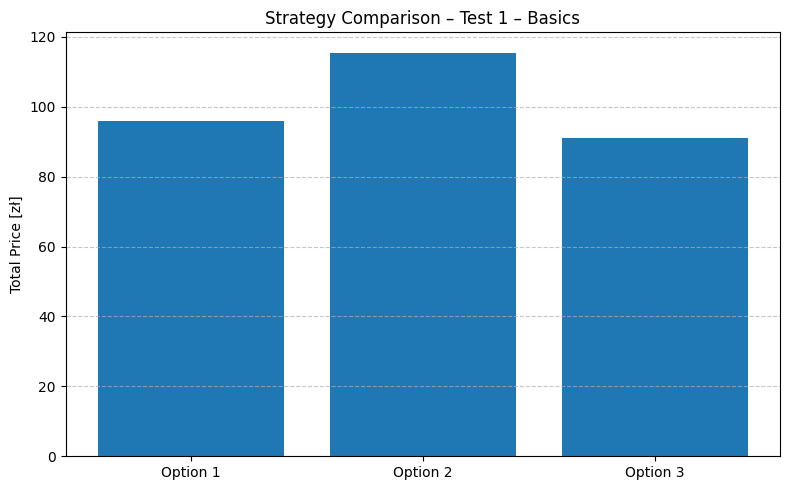


--- Test 2 – Classics ---

📚 Test 2 – Classics – Books to buy: ['Balladyna', 'Pan Tadeusz', 'Quo Vadis', 'Mały Książę']

💰 Option 1 – All books in one bookstore:
🏪 Bookstore 1: 104.50 zł
🏪 Bookstore 2: 111.00 zł
🏪 Bookstore 3: 83.50 zł
🏪 Bookstore 4: 108.10 zł
🏪 Bookstore 5: 103.75 zł

💰 Option 2 – Cheapest store per book: 139.50 zł

🏷️ Promotions used (Option 2):
Store 1: if total_price >= 100: shipping_cost = 0
Store 3: total_price -= sum(prices[:len(prices)//3])
Store 4: if len(prices) >= 3: total_price *= 0.9

💰 Option 3 – Optimal mixed-store combination: 83.50 zł

📦 Bookstore assignments (Option 3):
📘 Balladyna – Store 3 – 20.5 zł
📘 Pan Tadeusz – Store 3 – 24.5 zł
📘 Quo Vadis – Store 3 – 25.0 zł
📘 Mały Książę – Store 3 – 23.5 zł

🏷️ Promotions used (Option 3):
Store 3: total_price -= sum(prices[:len(prices)//3])


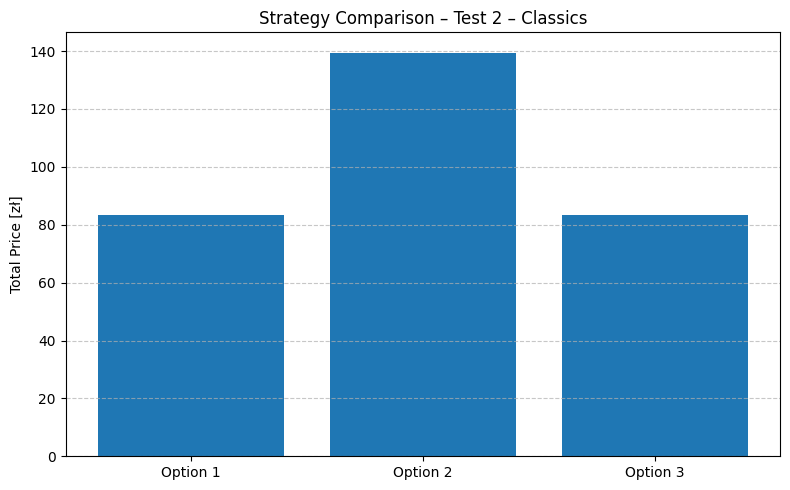


--- Test 3 – School Set ---

📚 Test 3 – School Set – Books to buy: ['Syzyfowe prace', 'Zemsta', 'Katarynka', 'Kamienie na szaniec']

💰 Option 1 – All books in one bookstore:
🏪 Bookstore 1: 108.50 zł
🏪 Bookstore 2: 118.50 zł
🏪 Bookstore 3: 90.50 zł
🏪 Bookstore 4: 107.65 zł
🏪 Bookstore 5: 112.55 zł

💰 Option 2 – Cheapest store per book: 143.50 zł

🏷️ Promotions used (Option 2):
Store 1: if total_price >= 100: shipping_cost = 0
Store 3: total_price -= sum(prices[:len(prices)//3])
Store 4: if len(prices) >= 3: total_price *= 0.9

💰 Option 3 – Optimal mixed-store combination: 90.50 zł

📦 Bookstore assignments (Option 3):
📘 Syzyfowe prace – Store 3 – 29.5 zł
📘 Zemsta – Store 3 – 21.0 zł
📘 Katarynka – Store 3 – 26.0 zł
📘 Kamienie na szaniec – Store 3 – 24.5 zł

🏷️ Promotions used (Option 3):
Store 3: total_price -= sum(prices[:len(prices)//3])


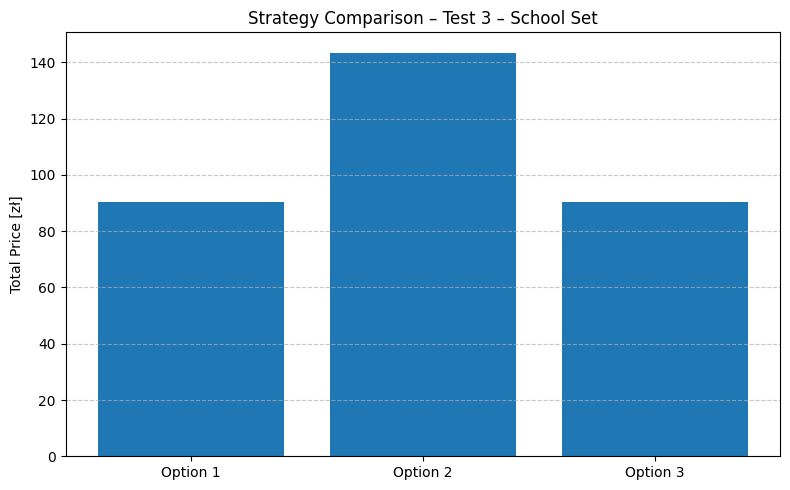


--- Test 4 – Light Set ---

📚 Test 4 – Light Set – Books to buy: ['Latarnik', 'Balladyna']

💰 Option 1 – All books in one bookstore:
🏪 Bookstore 1: 66.00 zł
🏪 Bookstore 2: 59.50 zł
🏪 Bookstore 3: 53.00 zł
🏪 Bookstore 4: 65.00 zł
🏪 Bookstore 5: 51.60 zł

💰 Option 2 – Cheapest store per book: 67.50 zł

🏷️ Promotions used (Option 2):
Store 3: total_price -= sum(prices[:len(prices)//3])

💰 Option 3 – Optimal mixed-store combination: 51.60 zł

📦 Bookstore assignments (Option 3):
📘 Latarnik – Store 5 – 23.0 zł
📘 Balladyna – Store 5 – 22.5 zł

🏷️ Promotions used (Option 3):
Store 5: if len(prices) >= 2: total_price -= sorted(prices)[1] * 0.3


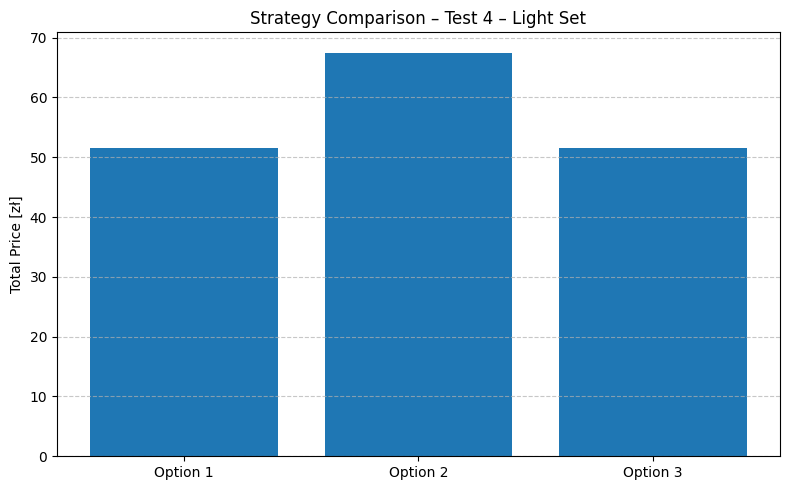


--- Test 5 – Extended ---

📚 Test 5 – Extended – Books to buy: ['Mały Książę', 'Zemsta', 'Pan Tadeusz', 'Opowieści z Narnii: Lew, czarownica i stara szafa']

💰 Option 1 – All books in one bookstore:
🏪 Bookstore 1: 114.00 zł
🏪 Bookstore 2: 115.50 zł
🏪 Bookstore 3: 87.50 zł
🏪 Bookstore 4: 102.70 zł
🏪 Bookstore 5: 106.50 zł

💰 Option 2 – Cheapest store per book: 128.50 zł

🏷️ Promotions used (Option 2):
Store 3: total_price -= sum(prices[:len(prices)//3])
Store 4: if len(prices) >= 3: total_price *= 0.9

💰 Option 3 – Optimal mixed-store combination: 87.50 zł

📦 Bookstore assignments (Option 3):
📘 Mały Książę – Store 3 – 23.5 zł
📘 Zemsta – Store 3 – 21.0 zł
📘 Pan Tadeusz – Store 3 – 24.5 zł
📘 Opowieści z Narnii: Lew, czarownica i stara szafa – Store 3 – 29.0 zł

🏷️ Promotions used (Option 3):
Store 3: total_price -= sum(prices[:len(prices)//3])


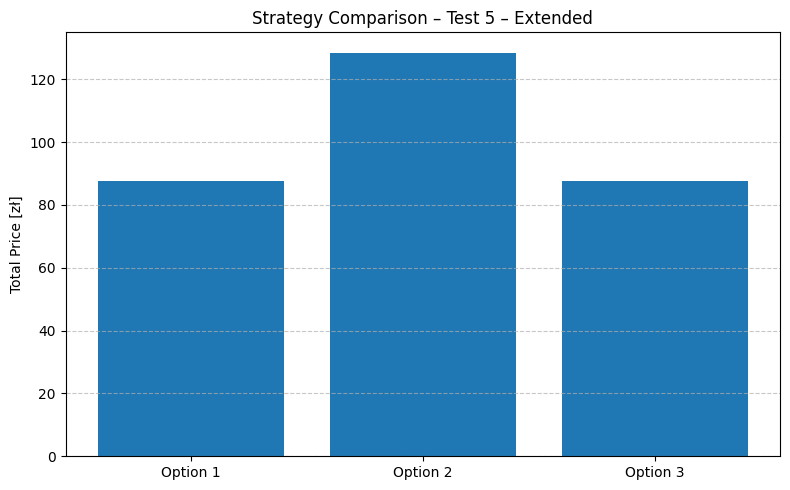

In [ ]:
import matplotlib.pyplot as plt

# Lista przypadków testowych
test_cases = [
    ("Test 1 – Basics", [
        "Opowieści z Narnii: Lew, czarownica i stara szafa",
        "W pustyni i w puszczy",
        "Akademia pana Kleksa",
        "Chłopcy z Placu Broni"
    ]),
    ("Test 2 – Classics", [
        "Balladyna", "Pan Tadeusz", "Quo Vadis", "Mały Książę"
    ]),
    ("Test 3 – School Set", [
        "Syzyfowe prace", "Zemsta", "Katarynka", "Kamienie na szaniec"
    ]),
    ("Test 4 – Light Set", [
        "Latarnik", "Balladyna"
    ]),
    ("Test 5 – Extended", [
        "Mały Książę", "Zemsta", "Pan Tadeusz", "Opowieści z Narnii: Lew, czarownica i stara szafa"
    ])
]

# Wygeneruj wykresy
for test_name, books in test_cases:
    print(f"\n--- {test_name} ---")
    result = compare_all_strategies(books, test_name)

    if result:
        labels = ["Option 1", "Option 2", "Option 3"]
        values = [result[1], result[2], result[3]]
        values = [v if v is not None else 0 for v in values]
        colors = ['skyblue', 'lightgreen', 'salmon']

        plt.figure(figsize=(8, 5))
        bars = plt.bar(labels, values, color=colors)

        # Dodaj wartości nad słupkami
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f} zł', 
                     ha='center', va='bottom', fontsize=10)

        plt.ylabel('Total Price [zł]')
        plt.title(f'Strategy Comparison – {test_name}')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
